In [3]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:46, 1896.47it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [37]:
# 1. Посчитайте количество отзывов в разных городах и на разные банки

cities = []
banks = []
    
# словарь городов, хоть немного уменьшим их количество вариантов за счет регистра
counter = {}
for i in responses:
    city = str(i['city']).lower()
    counter[city] = {}

# словарь банков в городах    
for i in responses:
    city = str(i['city']).lower()
    bank = str(i['bank_name']).lower()
    counter[city][bank] = 0
  

# считаем отзывы
for i in responses:
    city = str(i['city']).lower()
    bank = str(i['bank_name']).lower()
    counter[city][bank] += 1

counter

{'г. москва': {'бинбанк': 574,
  'гагаринский': 18,
  'тинькофф банк': 2388,
  'альфа-банк': 3969,
  'совкомбанк': 344,
  'московский кредитный банк': 2397,
  'сбербанк россии': 8321,
  'втб 24': 2753,
  'бенифит-банк': 109,
  'уральский банк реконструкции и развития': 42,
  'бинбанк кредитные карты': 393,
  'хоум кредит банк': 2190,
  'мдм банк': 217,
  'киви банк': 710,
  'русславбанк': 282,
  'маст-банк': 153,
  'национальный банк «траст»': 1693,
  'связной банк': 1457,
  'московский индустриальный банк': 99,
  'восточный экспресс банк': 411,
  'финансовый стандарт': 101,
  'русский стандарт': 2901,
  'юникредит банк': 1196,
  'банкирский дом': 21,
  'кредит европа банк': 622,
  'тройка-д банк': 13,
  'дельтакредит': 289,
  'ханты-мансийский банк открытие': 641,
  'фк открытие (бывш. номос-банк)': 230,
  'банк москвы': 1317,
  'росбанк': 589,
  'авангард': 1088,
  'росэнергобанк': 42,
  'российский капитал': 67,
  'росинтербанк': 318,
  'российский кредит': 80,
  'европлан банк': 11

In [7]:
# 2. Постройте гистограмы длин слов в символах и в словах. 
# судя по формулировке, все таки "количества слов в отзывах и символов в словах"

texts = []

for i in responses:
    texts.append(i['text'])

wcnt = []
lcnt = []
for i in texts:
    wcnt.append(len(i.split()))
    
for i in ' '.join(texts).split():
    lcnt.append(len(i)) 

In [64]:
wcnt = pd.DataFrame(wcnt)
lcnt = pd.DataFrame(lcnt)

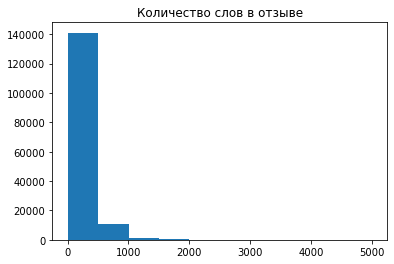

In [65]:
plt.hist(wcnt)
plt.title('Количество слов в отзыве')
plt.show()

In [67]:
lcnt.value_counts()
#образовались какие то выбросы из слов длинной 800+симоволов (видимо, отзыв был без пробелов) 
#не будем учитывать их в гистограмме

1      4542201
5      4017825
2      3856558
6      3839532
3      3822022
        ...   
130          1
127          1
126          1
115          1
841          1
Length: 163, dtype: int64

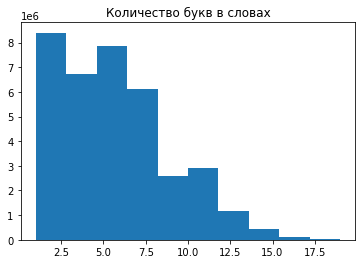

In [70]:
plt.hist(lcnt[lcnt[0]<20])
plt.title('Количество букв в словах')
plt.show()

In [18]:
# 2. Найдите 10 самых частых:
# слов

words = pd.DataFrame(' '.join(texts).split())

In [19]:
vc = words.value_counts()
vc.head(10)

в      1157262
и       965735
не      808409
на      632541
что     586864
я       427944
с       423586
по      333342
-       294086
мне     277035
dtype: int64

In [1]:
# слов без стоп-слов
nltk.download('stopwords')
mystopwords = nltk.corpus.stopwords.words('russian') + ['г.']

NameError: name 'nltk' is not defined

In [28]:
datastopwords = list(set(mystopwords) & set(words[0]))

In [35]:
wordssw = pd.DataFrame(list(set(words[0]).difference(datastopwords)))

In [38]:
wordssw.value_counts()


😳                         1
Злостнымнеплательщиком    1
Злоупотребив              1
Злоумышленнику            1
Злоумышленников           1
                         ..
навязчивость...           1
навязчивость.             1
навязчивость,             1
навязчивость              1
!                         1
Length: 1111724, dtype: int64

In [2]:
# лемм
# попытки установить mystem ни к чему не привели, вынужден пропустить
from pymystem3 import Mystem
m = Mystem()
m.lemmatize('навязано,')

Installing mystem to C:\Users\roma/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip


PermissionError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\roma\\AppData\\Local\\Temp\\tmp198lw0zl'

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined